In [1]:
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


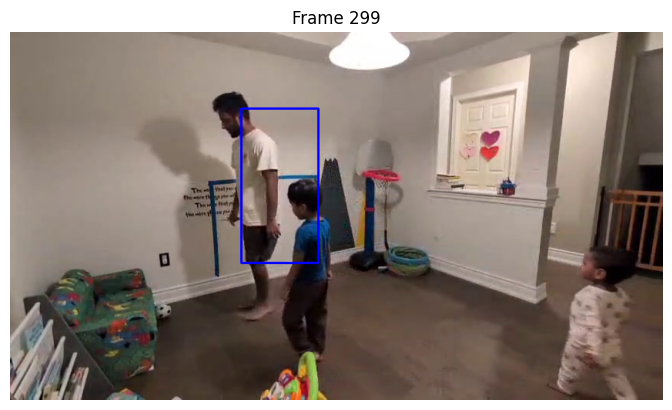

In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from ultralytics import YOLO

# Load YOLOv8 model (small for speed; use a custom model if trained on soccer balls)
model = YOLO("yolo11m.pt")

# Define goal box (pixel coordinates in the video frame)
goal_box = (300, 100, 400, 300)  # (x1, y1, x2, y2) - adjust for your video

# Load video
video_path = "../data/soccer_short_clip.mp4"  # Replace with your path
cap = cv2.VideoCapture(video_path)

# Helper to display frame inline
def show_frame(frame, title="Frame", scale=1.0):
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    h, w = frame.shape[:2]
    plt.figure(figsize=(w * scale / 100, h * scale / 100))
    plt.imshow(frame)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Keep track of entry to goal
last_inside = False
frame_idx = 0

# Run YOLO + BoT-SORT tracking loop
while cap.isOpened() and frame_idx < 300:  # limit for testing
    ret, frame = cap.read()
    if not ret:
        break

    # Track using built-in BoT-SORT (default)
    results = model.track(frame, persist=True, verbose=False)[0]

    # Draw goal box
    gx1, gy1, gx2, gy2 = goal_box
    cv2.rectangle(frame, (gx1, gy1), (gx2, gy2), (255, 0, 0), 2)

    # Check each object
    goal_scored = False
    if results.boxes is not None:
        for box in results.boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            conf = float(box.conf[0])
            cls = int(box.cls[0])
            track_id = int(box.id[0]) if box.id is not None else -1

            # Compute center point
            cx, cy = (x1 + x2) // 2, (y1 + y2) // 2

            # Optional: Filter to just soccer ball class (use correct class index)
            if cls != 32:  # Change to your object's class ID
                continue

            # Check if ball entered goal
            current_inside = gx1 <= cx <= gx2 and gy1 <= cy <= gy2
            if not last_inside and current_inside:
                goal_scored = True
                cv2.putText(frame, "GOAL!", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 255), 4)

            last_inside = current_inside

            # Draw box and label
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
            label = f"ID:{track_id} Ball" if track_id >= 0 else "Ball"
            cv2.putText(frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

    # Show frame inline
    clear_output(wait=True)
    show_frame(frame, title=f"Frame {frame_idx}")
    frame_idx += 1

cap.release()

In [27]:
from ultralytics import YOLO
from ultralytics import NAS
import cv2
import matplotlib.pyplot as plt
from IPython.display import clear_output

# model = YOLO("yolo11m.pt")  # Replace with your custom YOLOv11 model
model = YOLO("yolo12x")
cap = cv2.VideoCapture("../data/soccer_short_clip.mp4")

def show_frame(frame, title="Frame", scale=1.0):
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    h, w = frame.shape[:2]
    plt.figure(figsize=(w * scale / 100, h * scale / 100))
    plt.imshow(frame)
    plt.title(title)
    plt.axis('off')
    plt.show()

frame_idx = 0
while cap.isOpened() and frame_idx < 300:
    ret, frame = cap.read()
    if not ret:
        break

    results = model.predict(frame, verbose=False, imgsz=640)[0]

    for box in results.boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        cls = int(box.cls[0])
        conf = float(box.conf[0])

        # Optional: Only show specific class, like soccer ball
        if cls != 32:
            continue

        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 255), 2)
        cv2.putText(frame, f"{results.names[int(box.cls[0])]} {conf:.2f}", (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

    clear_output(wait=True)
    show_frame(frame, title=f"Frame {frame_idx}")
    frame_idx += 1

cap.release()


KeyboardInterrupt: 

'book'

In [19]:
from ultralytics.models.sam import SAM2VideoPredictor

# Create SAM2VideoPredictor
overrides = dict(conf=0.25, task="segment", mode="predict", imgsz=1024, model="sam2_b.pt")
predictor = SAM2VideoPredictor(overrides=overrides)

# Run inference with single point
results = predictor(source="../data/soccer_short_clip.mp4", points=[920, 470], labels=[1])

# # Run inference with multiple points
# results = predictor(source="test.mp4", points=[[920, 470], [909, 138]], labels=[1, 1])

# # Run inference with multiple points prompt per object
# results = predictor(source="test.mp4", points=[[[920, 470], [909, 138]]], labels=[[1, 1]])

# # Run inference with negative points prompt
# results = predictor(source="test.mp4", points=[[[920, 470], [909, 138]]], labels=[[1, 0]])


Ultralytics 8.3.105 🚀 Python-3.10.14 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3090, 24040MiB)


100%|██████████| 154M/154M [00:13<00:00, 11.6MB/s] 



WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/304) /workspace/code/../data/soccer_short_clip.mp4: 1024x1024 (no detections), 245.1ms
video 1/1 (frame 2/304) /workspace/code/../data/soccer_short_clip.mp4: 1024x1024 (no detections), 109.8ms
video 1/1 (frame 3/304) /workspace/code/../data/soccer_short_clip.mp4: 1024x1024 (no detections), 98.9ms
video 1/1 (frame 4/304) /workspace/code/../data/soccer_short_clip.mp4: 1024x1024 (no detections), 105.9ms
video 1/1 (frame 5/304) /workspace

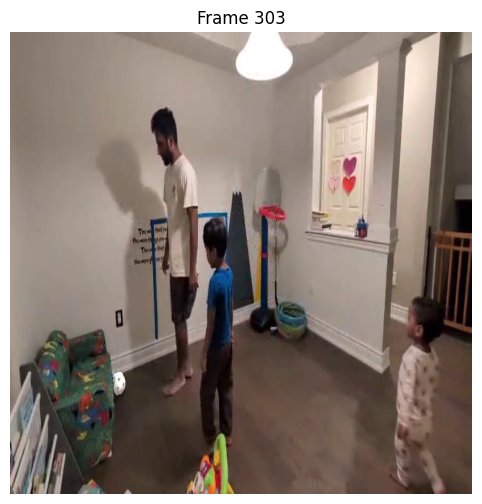


0: 384x640 2 persons, 1 couch, 1 tv, 2 books, 2.6ms
Speed: 0.9ms preprocess, 2.6ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 couch, 1 tv, 3 books, 10.8ms
Speed: 4.0ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 couch, 1 remote, 2 books, 10.6ms
Speed: 4.0ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 couch, 1 remote, 3 books, 3.4ms
Speed: 4.1ms preprocess, 3.4ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 couch, 1 remote, 2 books, 10.8ms
Speed: 4.0ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 couch, 1 remote, 1 book, 10.7ms
Speed: 4.0ms preprocess, 10.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 couch, 1 remote, 1 book, 3.4ms
Speed: 1.5ms preprocess, 3.

In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from ultralytics import YOLO, SAM

# Load models
detector = YOLO("yolov8s.pt")
segmenter = SAM("sam2.1_b.pt")

# Open the video
cap = cv2.VideoCapture("../data/soccer_short_clip.mp4")

# Setup matplotlib display
fig, ax = plt.subplots(figsize=(10, 6))
img_display = ax.imshow(np.zeros((10, 10, 3), dtype=np.uint8))
ax.axis('off')
display_handle = display(fig, display_id=True)
plt.close(fig)

# Tracking state
frame_count = 0
ball_found = False
prev_gray = None
prev_point = None

# === Begin frame-by-frame processing ===
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    overlay = frame.copy()

    if not ball_found:
        # Run YOLOv8 detection
        det_results = detector(frame)
        for box, cls in zip(det_results[0].boxes.xyxy, det_results[0].boxes.cls):
            if det_results[0].names[int(cls)] == "sports ball":
                x1, y1, x2, y2 = box.cpu().numpy().astype(int)
                cx, cy = (x1 + x2) // 2, (y1 + y2) // 2
                prev_point = np.array([[cx, cy]], dtype=np.float32)
                prev_gray = frame_gray.copy()

                # Use SAMv2 to segment
                sam_result = segmenter.predict(frame, points=[[cx, cy]], labels=[1])
                if sam_result[0].masks is not None:
                    mask = sam_result[0].masks.data[0].cpu().numpy().astype("uint8") * 255
                    colored_mask = cv2.merge([mask, mask, mask])
                    overlay = cv2.addWeighted(overlay, 1.0, colored_mask, 0.5, 0)
                    ball_found = True
                break
    else:
        # Use optical flow to track point
        next_point, status, _ = cv2.calcOpticalFlowPyrLK(prev_gray, frame_gray, prev_point, None)
        if status[0][0] == 1:
            cx, cy = next_point[0].astype(int)
            prev_point = next_point  # update for next round
            prev_gray = frame_gray.copy()

            # Use SAMv2 with tracked point
            sam_result = segmenter.predict(frame, points=[[cx, cy]], labels=[1])

            if sam_result[0].masks is not None:
                mask = sam_result[0].masks.data[0].cpu().numpy().astype("uint8") * 255
                if mask.sum() < 1000:
                    print("Mask too small — triggering YOLO re-detection.")
                    ball_found = False
                else:
                    colored_mask = cv2.merge([mask, mask, mask])
                    overlay = cv2.addWeighted(overlay, 1.0, colored_mask, 0.5, 0)

                    # Optionally: update point based on current mask center
                    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                    if contours:
                        x, y, w, h = cv2.boundingRect(contours[0])
                        new_center = np.array([[(x + w // 2), (y + h // 2)]], dtype=np.float32)
                        prev_point = new_center
                        prev_gray = frame_gray.copy()
            else:
                print("SAM failed — triggering YOLO re-detection.")
                ball_found = False
        else:
            print("Optical flow failed — triggering YOLO re-detection.")
            ball_found = False

    # Convert and display
    overlay_rgb = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)
    img_display.set_data(overlay_rgb)
    img_display.axes.set_title(f"Frame {frame_count}")
    display_handle.update(img_display.figure)

    time.sleep(0.3)
    frame_count += 1

cap.release()
print("Tracking complete.")


In [30]:
import cv2
import numpy as np
from ultralytics import YOLO
import matplotlib.pyplot as plt
from IPython.display import clear_output, display
import time

# Initialize YOLO model
model = YOLO("yolov8x.pt")  # or your custom-trained model

# Initialize video source (change to filename if needed)
video_path = "../data/soccer_short_clip.mp4"  # Replace with your path
cap = cv2.VideoCapture(video_path)

# Capture the first frame
ret, prev_frame = cap.read()
if not ret:
    print("Failed to read from camera")
    cap.release()
    exit()

prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)

# Function to display frames in Jupyter
def show_frame(img, figsize=(10, 6)):
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=figsize)
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.show()

# Run for a few frames or until manually stopped
frame_count = 0
MAX_FRAMES = 500  # Adjust as needed

while cap.isOpened() and frame_count < MAX_FRAMES:
    ret, frame = cap.read()
    if not ret:
        break
    frame_count += 1
    if frame_count < 180:
        continue

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Compute Farneback optical flow
    flow = cv2.calcOpticalFlowFarneback(prev_gray, gray,
                                        None, 0.5, 3, 15, 3, 5, 1.2, 0)
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    
    # # Threshold motion magnitude
    motion_mask = cv2.threshold(mag, 5.0, 255, cv2.THRESH_BINARY)[1].astype(np.uint8)
    motion_mask = cv2.dilate(motion_mask, None, iterations=2)

    contours, _ = cv2.findContours(motion_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for cnt in contours:
        # if cv2.contourArea(cnt) < 10:
        #     continue
        x, y, w, h = cv2.boundingRect(cnt)
        roi = frame[y:y+h, x:x+w]
        # results = model.predict(roi, conf=0.5, imgsz=320, verbose=False)
        
        # for result in results:
        #     for box in result.boxes:
        #         bx1, by1, bx2, by2 = map(int, box.xyxy[0])
        #         cv2.rectangle(frame, (x + bx1, y + by1), (x + bx2, y + by2), (0, 255, 0), 2)
        # Draw the contour box on the original frame
        # Define white-ish color range
        lower = np.array([0, 0, 160])
        upper = np.array([180, 60, 255])
        mask = cv2.inRange(roi, lower, upper)
        
        # Keep if enough of the region is white
        white_ratio = np.sum(mask > 0) / (w * h)
        if white_ratio < 0.1:
            continue
        
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 255), 2)  # Yellow box
    
        # Optional: label the box
        cv2.putText(frame, f"Motion", (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX,
                    0.5, (0, 255, 255), 1, cv2.LINE_AA)

    # Update previous frame
    prev_gray = gray.copy()

    # Display the current frame
    clear_output(wait=True)
    show_frame(frame)
    # plt.imshow(motion_mask, cmap='hot')
    # plt.title("Flow Magnitude")
    # plt.colorbar()
    # plt.show()
    time.sleep(0.01)  # Delay for smoother display

cap.release()


KeyboardInterrupt: 

In [14]:
motion_mask.shape

(478, 848)